Imported all of the modules

In [80]:
# Importing modules---------------------------------------------
import pandas as pd #To import dataset
import re #To modify the text, i.e to remove punctuations
from wordcloud import WordCloud #To create wordclouds
import gensim #For topic modeling and natural language processing
from gensim.utils import simple_preprocess #Converts document into unicode strings
import gensim.corpora as corpora #A corpus library to store text documents
from gensim.models import CoherenceModel #To calculate topic coherence for topic models
import nltk #To process natural language
from nltk.corpus import stopwords #To remove unnecessary words from the string
from pprint import pprint #To maintain the format of non fundamental Python types
import spacy #To preprocess the string for later analysis
import pickle #To convert python objects into byte streams
import pyLDAvis #Aids in interpreting the topics created in a topic model
import pyLDAvis.gensim_models #For topic modelling, document indexing and similarity retrieval
import numpy as np #For manipulating arrays
import tqdm as tqdm #To show the progress of iteration loops (The percentage that is completed)
import matplotlib.pyplot as plt #For data visualization



/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The .csv file is uploaded, then removed the columns that were not needed for analysis. I only kept the bill number and bill text

In [7]:

#Obtaining and filtering data-------------------------------------
docs = pd.read_csv('/Users/jhaelle/Desktop/PythonRB/bills.csv')
docs = docs.drop(columns=['Success', 'Sponsors', 'Type of Bill','Committees'], axis=1).sample(42)


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From the "Text" column in "docs" all punctuations are removed and all words are lowercased. Then the first 5 rows are printed to ensure I obtained the desired preprocessed result.

In [8]:

#Preprocessing---------------------------------------------------
# Punctuation
docs['Text_processed'] = \
docs['Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Lowercase
docs['Text_processed'] = \
docs['Text_processed'].map(lambda x: x.lower())
# Print
docs['Text_processed'].head()


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<ipython-input-8-428a8c300192>:4: DeprecationWarning: invalid escape sequence \.
  docs['Text'].map(lambda x: re.sub('[,\.!?]', '', x))


9     as passed senate a bill to be entitled an act ...
41    a bill to be entitled an act 1 to amend chapte...
6     a bill to be entitled an act 1 to amend code s...
42    a bill to be entitled an act 1 to amend chapte...
29    a bill to be entitled an act 1 to amend chapte...
Name: Text_processed, dtype: object

A word cloud is produced to visually reveal any other unnecessary words that needs to be removed.

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


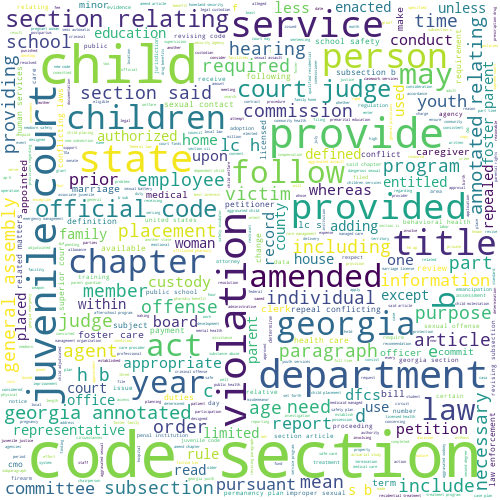

In [59]:

#Verify Preprocessing---------------------------------------------
# Join all texts together
cloud = ','.join(list(docs['Text_processed'].values))
# WordCloud object
wordcloud = WordCloud(width=500, height= 500, background_color="white", max_words=5000, contour_width=2, contour_color='red')
# Produce
wordcloud.generate(cloud)
# Visualize
wordcloud.to_image()


Removes the stopwords identified in the word cloud as unnecessary to create a string of words that will be most significant in developing topics

In [65]:

#Remove Stopwords---------------------------------------------
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['georgia', 'section', 'b','c','shall','may' 'related','matters','code','annotated','relating','article','member','law','amended','state','chapter','title','subsection'])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = docs.Text_processed.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jhaelle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['passed', 'senate', 'bill', 'entitled', 'act', 'amend', 'official', 'general', 'provisions', 'regarding', 'parks', 'historic', 'areas', 'memorials', 'recreation', 'juvenile', 'programs', 'protection', 'children', 'youth', 'respectively', 'strengthen', 'laws', 'supports', 'foster', 'children', 'foster', 'families', 'provide', 'definitions']


A collection of the bill text was created, each word in the collection was given an ID number, and the frequency of each term was calculated. Then it printed out the the frequency of each ID number (ID number, frequency).

In [66]:

#Create Corpus----------------------------------------------------
#Dictionary
id2word = corpora.Dictionary(data_words)
# Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 6), (8, 1), (9, 5), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 4), (17, 1), (18, 4), (19, 1), (20, 3), (21, 2), (22, 13), (23, 2), (24, 1), (25, 1), (26, 4), (27, 7), (28, 6), (29, 1), (30, 1)]


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To build the Latent Dirichlet allocation model the number of topics was set to 10 for simplicity, other parameters are default. Then, it printed the weight each keyword has within its topic.

In [68]:

#Topic Modeling----------------------------------------------------
#LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10)
# Prints weighted keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.029*"court" + 0.018*"shall" + 0.017*"juvenile" + 0.015*"child" + '
  '0.010*"judge" + 0.008*"provide" + 0.007*"care" + 0.007*"violation" + '
  '0.006*"judges" + 0.006*"services"'),
 (1,
  '0.016*"shall" + 0.013*"sexual" + 0.013*"offense" + 0.012*"employee" + '
  '0.012*"violation" + 0.011*"agent" + 0.009*"person" + 0.009*"child" + '
  '0.007*"court" + 0.007*"children"'),
 (2,
  '0.028*"child" + 0.020*"shall" + 0.010*"court" + 0.009*"violation" + '
  '0.009*"services" + 0.008*"juvenile" + 0.008*"school" + 0.008*"care" + '
  '0.008*"provide" + 0.007*"offense"'),
 (3,
  '0.028*"shall" + 0.022*"child" + 0.016*"court" + 0.010*"care" + '
  '0.008*"juvenile" + 0.008*"provide" + 0.007*"judge" + 0.007*"health" + '
  '0.007*"services" + 0.006*"provided"'),
 (4,
  '0.023*"shall" + 0.010*"committee" + 0.009*"child" + 0.008*"court" + '
  '0.007*"provide" + 0.006*"juvenile" + 0.005*"department" + 0.005*"services" '
  '+ 0.005*"health" + 0.005*"school"'),
 (5,
  '0.020*"child" + 0.016*"shal

Similar to the process above, except this groups 2 and 3 word phrases together to be used for the Latent Dirichlet allocation model. To prepare these phrases for analysis, the stopwords are removed and some keywords are converted to their base form. The final keywords are printed in a string.

In [13]:
#Phrase Modeling for Bigrams and Trigrams----------------------------------------------------------
# Build the models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(['georgia', 'section', 'b','c' 'related','matters','code','annotated','relating','article','member','law','amended','state','chapter','title','subsection'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adjective, verb and adverb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['pass', 'bill_entitled', 'act', 'amend_official', 'general', 'provision', 'regard', 'park', 'historic', 'area', 'memorial', 'recreation', 'juvenile', 'program', 'protection', 'child', 'youth', 'respectively', 'strengthen', 'law', 'support', 'foster', 'child', 'foster', 'family', 'provide', 'definition', 'provide', 'free', 'access', 'park', 'foster', 'parent', 'provide', 'report', 'certain', 'datum', 'juvenile', 'court', 'clerk', 'foster', 'child', 'allege', 'adjudicated', 'child', 'need', 'service', 'delinquent', 'child', 'provide', 'attorney', 'conflict', 'resolution', 'certain', 'juvenile', 'court', 'hearing', 'authorize', 'department', 'human', 'service', 'partner', 'child', 'place', 'agency', 'assist', 'casework', 'service', 'provide', 'varying', 'level', 'training', 'require', 'experienced', 'foster', 'parent', 'respite', 'caregiver', 'provide', 'conflicting_law', 'purposes_enacte', 'general_assembly', 'official', 'general', 'provision', 'regard', 'park', 'historic', 'area', 'me

A collection of the phrases and keywords was created, each phrase/keyword in the collection was given an ID number, and the frequency of each was calculated. Then it printed out the the frequency of each ID number (ID number, frequency).

In [14]:
#Create Corpus----------------------------------------------------
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 6), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 2), (14, 2), (15, 1), (16, 2), (17, 1), (18, 4), (19, 1), (20, 5), (21, 13), (22, 2), (23, 1), (24, 1), (25, 3), (26, 13), (27, 1), (28, 4), (29, 4), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 2), (42, 5), (43, 3), (44, 1), (45, 3), (46, 8), (47, 1), (48, 1), (49, 1), (50, 4), (51, 4), (52, 8), (53, 3), (54, 1), (55, 2), (56, 2), (57, 1), (58, 2), (59, 4), (60, 3), (61, 1), (62, 1), (63, 2), (64, 1), (65, 2), (66, 25), (67, 1), (68, 2), (69, 4), (70, 7), (71, 3), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 76), (78, 1), (79, 1), (80, 3), (81, 8), (82, 4), (83, 2), (84, 1), (85, 1), (86, 1), (87, 5), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 4), (94, 1), (95, 1), (96, 3), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 2), (106, 2), (107, 1), (108, 1), (109, 8), (110

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To build the Latent Dirichlet allocation model for phrases the general parameters and the number of topics were maintained. The chunksize determines how many documents are processed at one time, 100 was chosen for efficancy and speed. The passes determines how often the model is trained on the documents, 10 was chosen to maintain efficancy while using the highest amount possible. The model also computed a list of topics in descending order of most likely topics for each word with their phi values multiplied by the word count

In [15]:
#LDA model--------------------------------------------------------
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It printed the weight each phrase/keyword has within its topic.

In [16]:
#Print the Keyword in the 10 topics-------------------------------
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"violation" + 0.044*"offense" + 0.039*"sexual" + 0.021*"person" + '
  '0.020*"child" + 0.017*"individual" + 0.017*"provide" + 0.013*"contact" + '
  '0.013*"aggravate" + 0.010*"convict"'),
 (1,
  '0.041*"child" + 0.020*"family" + 0.018*"treatment" + 0.012*"duty" + '
  '0.012*"program" + 0.012*"qualified_residential" + 0.012*"service" + '
  '0.011*"provide" + 0.011*"need" + 0.010*"officer"'),
 (2,
  '0.022*"provide" + 0.019*"child" + 0.014*"care" + 0.012*"court" + '
  '0.010*"woman" + 0.009*"person" + 0.008*"health" + 0.008*"mean" + '
  '0.007*"include" + 0.007*"order"'),
 (3,
  '0.082*"school" + 0.032*"safety" + 0.027*"public" + 0.026*"provide" + '
  '0.022*"agency" + 0.018*"plan" + 0.015*"board" + 0.015*"local" + '
  '0.015*"education" + 0.011*"student"'),
 (4,
  '0.001*"court" + 0.001*"provide" + 0.001*"child" + 0.001*"service" + '
  '0.001*"judge" + 0.001*"juvenile" + 0.001*"care" + 0.001*"health" + '
  '0.001*"school" + 0.001*"follow"'),
 (5,
  '0.032*"committee" + 0.0

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The Perplexity was computed to understand the accuracy of the model. The lower the perplexity is, the better.
The Coherence Score was computed to measure the relative distance between keywords within a topic. 

In [17]:
# Perplexity and Coherence Score--------------------------------------------------
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.446167795299904


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4241751167352971


To have a better understanding of the hyperparameters to use, the algorithm will perform multiple sensitivity tests to determine the number of topics, the value of alpha(document-topic density) and the value of beta (word-topic density).

In [87]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The function is called, and iterated over the range of topics, alpha, and beta parameter values. The range for topics was determined by subjective reasoning, anything less than 2 would create broad topics while anything over 11 would create unnecessary topics that does not give useful information because the same keywords will be repeated in multiple topics. After the iterations, the results are saved in a .csv file.

In [42]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # Iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # Iterate through number of topics
        for k in topics_range:
            # Iterate through alpha values
            for a in alpha:
                # Iterate through beta values
                for b in beta:
                    # Coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save model 
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

  0%|          | 0/540 [58:41<?, ?it/s]

100%|██████████| 540/540 [7:49:13<00:00, 52.14s/it]


This graph is a measure of the coherence score per number of topics. After 6 topics there is drop off in coherence scores, therefore the value of the parameter for number of topics is 6. The value of the alpha and beta parameter corresponds with the highest coherence score for 7 topics, which are .91 and .61 respectively.

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


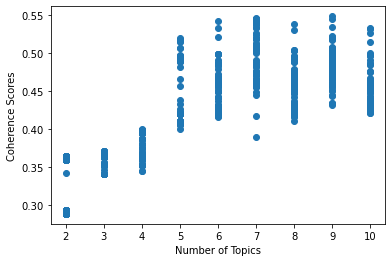

In [106]:
data=pd.read_csv('/Users/jhaelle/Desktop/PythonRB/LDAResults.csv')
plt.scatter(data.Topics, data.Coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

This is the final Latent Dirichlet allocation model with all parameter values. 

In [111]:
#Final Model----------------------------------------------
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.61)

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


A visualization of the most relevant terms for each topic.

In [112]:
#Visualize------------------------------------------------
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/jhaelle/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.104165 -0.014239       1        1  31.965980
0     -0.092352 -0.035359       2        1  20.790188
2     -0.023186  0.085702       3        1  16.508191
3      0.073257  0.068045       4        1  15.624483
5      0.075803 -0.075393       5        1   7.898028
1      0.070643 -0.028755       6        1   7.213129, topic_info=          Term        Freq       Total Category  logprob  loglift
96       child  400.000000  400.000000  Default  30.0000  30.0000
500     school   87.000000   87.000000  Default  29.0000  29.0000
565  violation  156.000000  156.000000  Default  28.0000  28.0000
138      court  273.000000  273.000000  Default  27.0000  27.0000
296      judge   86.000000   86.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
505   services    6.717008  159.143809   Topic6  -5.6251  -0.5359
437   purposes    4.926654   54.000530   Topic6  -5.9351   0.2349
739         lc    4.775343   77.902053   Topic6  -5.9663  -0.1627
330        may    4.278135  100.492369   Topic6  -6.0762  -0.5273
902   violence    4.267962   18.824809   Topic6  -6.0786   1.1452

[375 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1495      1  0.185087  abolishment
1495      6  0.555262  abolishment
4         1  0.179125        abuse
4         2  0.626938        abuse
4         3  0.044781        abuse
...     ...       ...          ...
579       3  0.022510        youth
579       4  0.045020        youth
579       5  0.360160        youth
579       6  0.067530        youth
580       1  0.902179       youths

[994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 6, 2])